In [1]:
import math
import warnings
import numpy as np
import mindspore as ms
import mindspore.nn as nn
import mindspore.ops as ops
import mindspore.numpy as mnp
import matplotlib.pyplot as plt
import mindspore.context as context
from mindspore import Tensor, Parameter
from typing import Union, List, Tuple, Optional


context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

rgb_to_ycbcr = Tensor([
    [0.299000,  0.587000,  0.114000],
    [-0.168736, -0.331264,  0.500000],
    [0.500000, -0.418688, -0.081312]
], dtype=ms.float32)


rgb_to_ycbcr_bias = Tensor([0, 0.5, 0.5], dtype=ms.float32)

class RGBToYCbCr(nn.Cell):
    """Converts a tensor from RGB to YCbCr color space.
    Using transform from https://github.com/libjpeg-turbo/libjpeg-turbo/blob/master/jccolor.c
    """
    def __init__(self):
        super(RGBToYCbCr, self).__init__()

        self.transform = Parameter(rgb_to_ycbcr[:, :, None, None], name='transform', requires_grad=False)
        self.transform_bias = Parameter(rgb_to_ycbcr_bias[None, :, None, None], name='transform_bias', requires_grad=False)

    def construct(self, x: Tensor):
        return ops.conv2d(x, self.transform, self.transform_bias)
    
# Base matrix for luma quantization
T_luma = Tensor([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
], dtype=ms.float32)

# Chroma quantization matrix
Q_chroma = Tensor([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
], dtype=ms.float32)

def Q_luma(q: float) -> Tensor:
    """Generate the luma quantization matrix

    Args:
        q (float): Quality parameter (1-100)
    """
    s = 5000. / q if q < 50 else 200 - 2 * q
    return ops.floor((s * T_luma + 50) / 100)

def zigzag(n: int) -> Tensor:
    """Generates a zigzag position encoding tensor. 
    Source: https://stackoverflow.com/questions/15201395/zig-zag-scan-an-n-x-n-array
    """

    pattern = ms.numpy.zeros((n, n))
    triangle = lambda x: (x * (x + 1)) / 2

    # even index sums
    for y in range(n):
        for x in range(y % 2, n - y, 2):
            pattern[y, x] = triangle(x + y + 1) - x - 1

    # odd index sums
    for y in range(n):
        for x in range((y + 1) % 2, n - y, 2):
            pattern[y, x] = triangle(x + y + 1) - y - 1

    # bottom right triangle
    for y in range(n - 1, -1, -1):
        for x in range(n - 1, -1 + (n - y), -1):
            pattern[y, x] = n * n - 1 - pattern[n - y - 1, n - x - 1]

    return pattern.T

class DCTCompression(nn.Cell):
    def __init__(self, N=8, q=50):
        super(DCTCompression, self).__init__()

        self.N = N

        # Create all N² frequency squares
        # The DCT's result is a linear combination of those squares.
        
        us = ms.numpy.arange(N).reshape(N, 1) / N 
        vs = us.T # N×N

        xy = ms.numpy.arange(N, dtype=ms.float32)

        # freqs: (2x + 1)uπ/(2B) or (2y + 1)vπ/(2B)
        freqs = ((xy + 0.5) * np.pi).reshape(-1, 1, 1)

        # Extended dim
        cus = ops.cos(us * freqs).expand_dims(1)
        cvs = ops.cos(vs * freqs).expand_dims(0)

        # calculate the 64 (if N=8) frequency squares
        freq_sqs = cus * cvs

        # Put freq squares in format N²×1×N×N (same as kernel size of convolution)
        # Use plt.imshow(torchvision.utils.make_grid(BlockDCT.weight, nrow = BlockDCT.N)) to visualize
        self.weight = Tensor(freq_sqs.reshape(N * N, 1, N, N), ms.float32)

        zigzag_vector = zigzag(self.N).reshape(-1).astype(ms.int32)
        self.zigzag_weight = ops.OneHot()(zigzag_vector, depth=zigzag_vector.max() + 1, on_value=ms.Tensor(1.0, ms.float32), off_value=ms.Tensor(0.0, ms.float32)).inverse()[:, :, None, None]
        
        # matrix with sqrt(2)/2 at u=y=0
        norm_matrix = ops.ones((N, N))
        norm_matrix[:, 0] = ms.numpy.sqrt(Tensor(2.)) / 2
        norm_matrix[0, :] = norm_matrix[:, 0]
        norm_matrix /= 4

        norm_weight = norm_matrix.view(N * N, 1).repeat(N * N, axis=1) * ops.Eye()(N * N, N * N, ms.float32)
        self.norm_weight = ms.Parameter(norm_weight[:, :, None, None], requires_grad=False)

        quant_vals_tiled = 1 / ops.cat((Q_luma(q).view(64), Q_luma(q).view(64), Q_luma(q).view(64)), axis=0).tile((3 * N * N, 1))
        eye_matrix = ops.eye(3 * N * N, 3 * N * N, ms.float32)
        quant_weight = quant_vals_tiled * eye_matrix
        self.quant_weight = quant_weight[:, :, None, None]

    def construct(self, x: Tensor):
        B, C, H, W = x.shape
        assert H % self.N == 0 and W % self.N == 0, "Images size must be multiple of N (TBD)"

        out = x.view(-1, 1, H, W)
        out = ops.conv2d(out, weight=self.weight, stride=self.N)
        out = ops.conv2d(out, self.norm_weight)
        out = ops.conv2d(out, self.zigzag_weight)
        out = out.view(B, C*self.N*self.N, H//self.N, W//self.N)
        out = ops.conv2d(out, self.quant_weight)
        return out

# Implement torchvision.utils.make_grid functions
def make_grid(
    tensor: Union[Tensor, List[Tensor]],
    nrow: int = 8,
    padding: int = 2,
    normalize: bool = False,
    value_range: Optional[Tuple[int, int]] = None,
    scale_each: bool = False,
    pad_value: int = 0,
    **kwargs
) -> Tensor:
    """
    Make a grid of images.

    Args:
        tensor (Tensor or list): 4D mini-batch Tensor of shape (B x C x H x W)
            or a list of images all of the same size.
        nrow (int, optional): Number of images displayed in each row of the grid.
            The final grid size is ``(B / nrow, nrow)``. Default: ``8``.
        padding (int, optional): amount of padding. Default: ``2``.
        normalize (bool, optional): If True, shift the image to the range (0, 1),
            by the min and max values specified by ``value_range``. Default: ``False``.
        value_range (tuple, optional): tuple (min, max) where min and max are numbers,
            then these numbers are used to normalize the image. By default, min and max
            are computed from the tensor.
        scale_each (bool, optional): If ``True``, scale each image in the batch of
            images separately rather than the (min, max) over all images. Default: ``False``.
        pad_value (float, optional): Value for the padded pixels. Default: ``0``.

    Returns:
        grid (Tensor): the tensor containing grid of images.
    """
    if not (isinstance(tensor, Tensor) or
            (isinstance(tensor, list) and all(isinstance(t, Tensor) for t in tensor))):
        raise TypeError(f'tensor or list of tensors expected, got {type(tensor)}')

    if "range" in kwargs.keys():
        warning = "range will be deprecated, please use value_range instead."
        warnings.warn(warning)
        value_range = kwargs["range"]

    # if list of tensors, convert to a 4D mini-batch Tensor
    if isinstance(tensor, list):
        tensor = ops.stack(tensor, 0)

    if tensor.dim() == 2:  # single image H x W
        tensor = ops.ExpandDims()(tensor, 0)
    if tensor.dim() == 3:  # single image
        if tensor.shape[0] == 1:    # if single-channel, convert to 3-channel
            tensor = ops.cat((tensor, tensor, tensor), axis=0)
        tensor = ops.ExpandDims()(tensor, 0)

    if tensor.dim() == 4 and tensor.shape[1] == 1: 
        tensor = ops.cat((tensor, tensor, tensor), axis=1)

    if normalize:
        tensor = tensor.copy()
        if value_range is not None:
            assert isinstance(value_range, tuple), \
                "value_range has to be a tuple (min, max) if specified. min and max are numbers"

        def norm_ip(img, low, high):
            clamp = ops.clip_by_value(img, low, high)
            sub = ops.Sub()
            div = ops.Div()
            img = sub(clamp, low)
            img = div(img, ops.maximum(high - low, 1e-5))
            return img

        def norm_range(t, value_range):
            if value_range is not None:
                return norm_ip(t, value_range[0], value_range[1])
            else:
                return norm_ip(t, t.min(), t.max())

        if scale_each:
            for i in range(tensor.shape[0]):  # 循环遍历小批量维度
                tensor[i] = norm_range(tensor[i], value_range)
        else:
            tensor = norm_range(tensor, value_range)

    if tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)
    
    # make the mini-batch of images into a grid
    nmaps = tensor.shape[0]
    xmaps = min(nrow, nmaps)
    ymaps = int(math.ceil(float(nmaps) / xmaps))
    height, width = int(tensor.shape[2] + padding), int(tensor.shape[3] + padding)
    num_channels = tensor.shape[1]
    
    grid = mnp.full((num_channels, height * ymaps + padding, width * xmaps + padding), pad_value, dtype=ms.float32)
    
    k = 0
    for y in range(ymaps):
        for x in range(xmaps):
            if k >= nmaps:
                break
            # Tensor.copy_() is a valid method but seems to be missing from the stubs
            # https://pytorch.org/docs/stable/tensors.html#torch.Tensor.copy_
            grid[:, y * height + padding : y * height + padding + height - padding, x * width + padding : x * width + padding + width - padding] = tensor[k]

            k = k + 1
    return grid

/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/ma-user/anaconda3/envs/MindSpore/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
dct = DCTCompression()

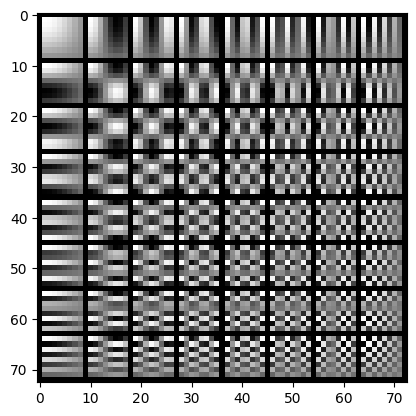

In [3]:
weights = (dct.weight+1)/2 # from (-1,1) to (0,1)
im_grid = make_grid(weights, nrow=8, padding=1)
plt.imshow(im_grid.asnumpy().transpose(1,2,0))
plt.show()

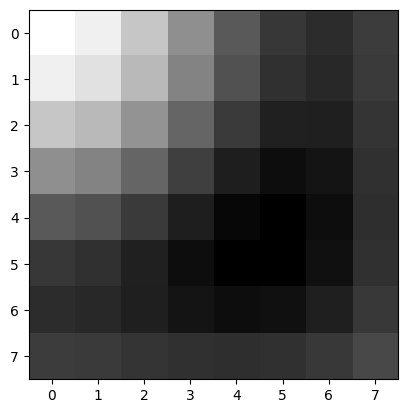

In [4]:
# DCT transform should yield high values at position 1 and 2 
# (not 1 and 8 because of zigzag ordering)
img = (weights[1] + weights[8])/2
img = (img+1)/2 * 255

plt.imshow(img.asnumpy().transpose(1,2,0), cmap='gray')
plt.show()

In [6]:
img3 = img.expand_dims(0).tile((1, 3, 1, 1))  # Need batched and 3 channels
img3 = (img3 + 1) / 2 * 255
ops.round(dct(img3)).view(192)

Tensor(shape=[192], dtype=Float32, value= [ 8.62400000e+03, -1.18400000e+03, -1.30200000e+03,  2.28000000e+03,  5.27000000e+02,  9.12000000e+02, -1.70000000e+01, -1.24000000e+02, -6.30000000e+02, -7.00000000e+01,  1.70000000e+03,  1.74000000e+02, 
  5.05000000e+02,  5.70000000e+01,  3.97000000e+02,  1.35000000e+02, -2.76000000e+02, -3.50000000e+01, -2.80000000e+01, -1.61000000e+02,  1.86000000e+02,  3.08000000e+02,  1.30000000e+01,  1.52000000e+02, 
  4.20000000e+01,  5.01000000e+02,  4.10000000e+01,  6.05000000e+02,  2.49000000e+02, -2.40000000e+01,  3.20000000e+01, -2.00000000e+00, -6.00000000e+00,  1.16000000e+02, -5.50000000e+01,  2.27000000e+02, 
 -9.00000000e+00,  5.70000000e+01,  3.00000000e+00,  7.30000000e+01,  1.50000000e+01,  1.78000000e+02, -1.10000000e+01,  7.00000000e+01,  1.00000000e+00,  1.70000000e+01,  1.60000000e+01,  1.00000000e+00, 
  9.10000000e+01,  3.00000000e+00,  5.30000000e+01,  1.00000000e+01,  4.00000000e+01,  2.00000000e+00,  2.50000000e+01,  1.40000000e+0